# IMPORT DATA

In [ ]:
# Library untuk mengakses Google Drive dan mengakses direktori
from google.colab import drive
import os

# Library untuk membuka dan menyimpan citra
from PIL import Image

# Library untuk menampilkan hasil tiap tahapan pengolahan citra
import seaborn as sns
import matplotlib.pyplot as plt
import random

#Library untuk hyperparameter tuning gridsearchcv
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

In [ ]:
# Library untuk mengakses Google Drive dan mengakses direktori
from google.colab import drive
import os, glob, pickle

# Akses ke Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/PPDM/VOICE/DATASET/voiceindo/voice/IndoWaveSentiment/'

/content/drive/MyDrive/PPDM/VOICE/DATASET/voiceindo/voice/IndoWaveSentiment


# Labeling Data

In [ ]:
import os
import glob
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

# emosi yang ada
emotions = {
    '01': 'neutral',
    '02': 'happy',
    '03': 'surprise',
    '04': 'disgust',
    '05': 'disappointed',
}

# emosi yang di observasi
observed_emotions = ['neutral', 'happy', 'surprise', 'disgust', 'disappointed']

# load data
def load_data():
    labels = []
    durations = []
    path = []
    for file in glob.glob("/content/drive/MyDrive/PPDM/VOICE/DATASET/voiceindo/voice/IndoWaveSentiment/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[1]]
        if emotion in observed_emotions:
            labels.append(emotion)

            #durasi pakai librosa
            duration = calculate_duration(file)
            durations.append(duration)
            path.append(file)

    return durations, labels, path

# durasi dengan librosa
def calculate_duration(file_path):
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    return duration

durations, labels, path = load_data()
df_labeling = pd.DataFrame({'duration': durations, 'emotion': labels, 'path':path})
print(df_labeling.sample(5))

num_rows, num_columns = df_labeling.shape
print(f"Total Data: {num_rows}")


     duration       emotion                                               path
99        3.0      surprise  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
6         3.0         happy  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
26        3.3  disappointed  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
109       3.0       neutral  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
199       3.8  disappointed  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
Total Data: 300


In [ ]:
df_labeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duration  300 non-null    float64
 1   emotion   300 non-null    object 
 2   path      300 non-null    object 
dtypes: float64(1), object(2)
memory usage: 7.2+ KB


# SAMPLE DATA

Emotion: disappointed, Path: /content/drive/MyDrive/PPDM/VOICE/DATASET/voiceindo/voice/IndoWaveSentiment/Actor_04/04-05-01-03.wav


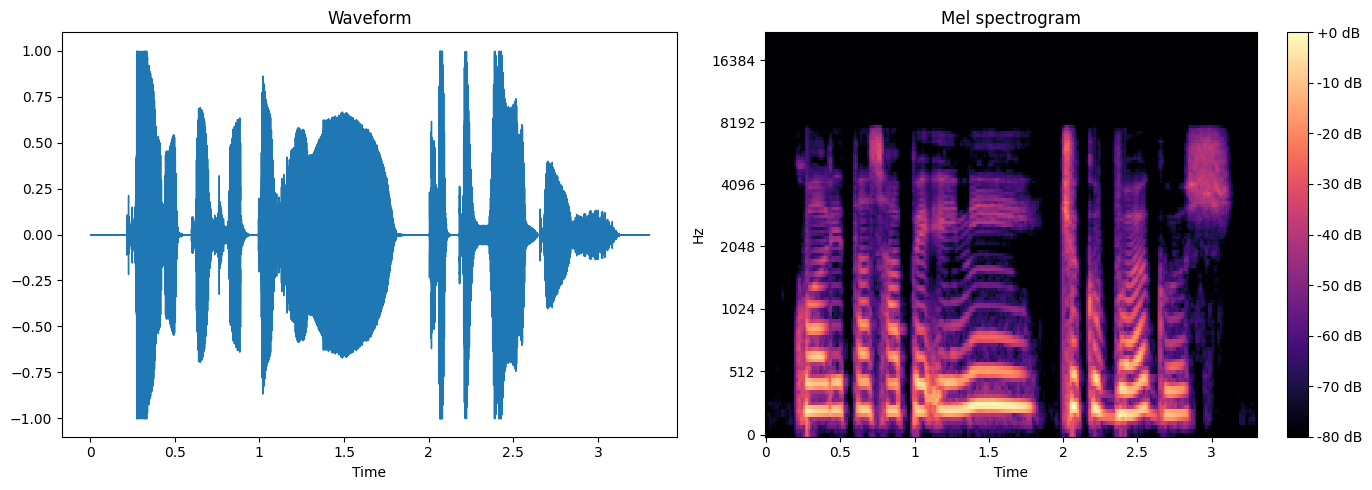

Emotion: disgust, Path: /content/drive/MyDrive/PPDM/VOICE/DATASET/voiceindo/voice/IndoWaveSentiment/Actor_04/04-04-01-01.wav


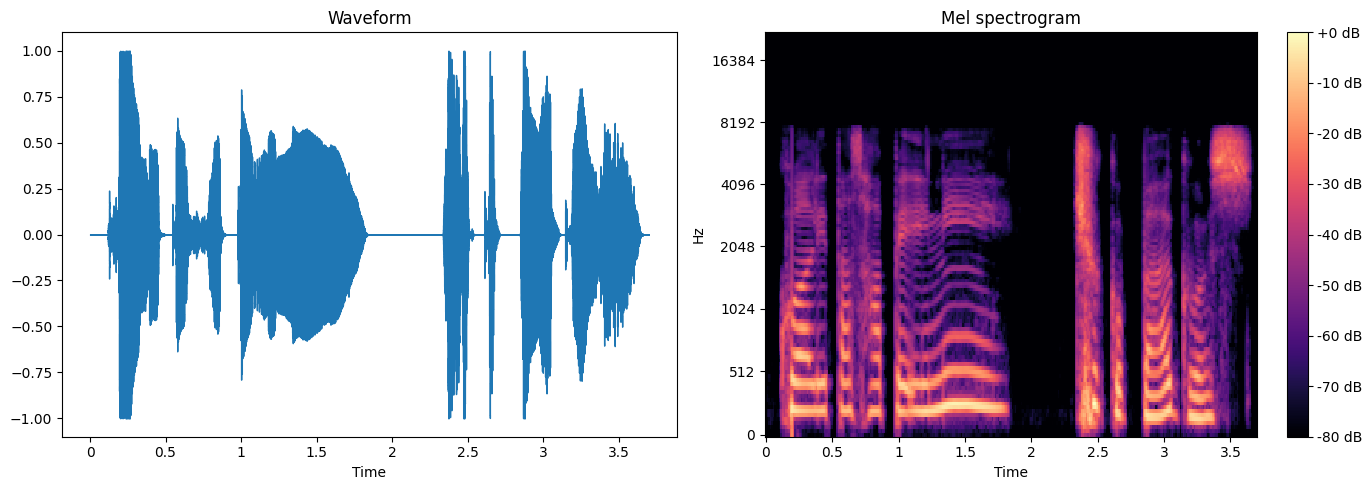

Emotion: happy, Path: /content/drive/MyDrive/PPDM/VOICE/DATASET/voiceindo/voice/IndoWaveSentiment/Actor_04/04-02-01-01.wav


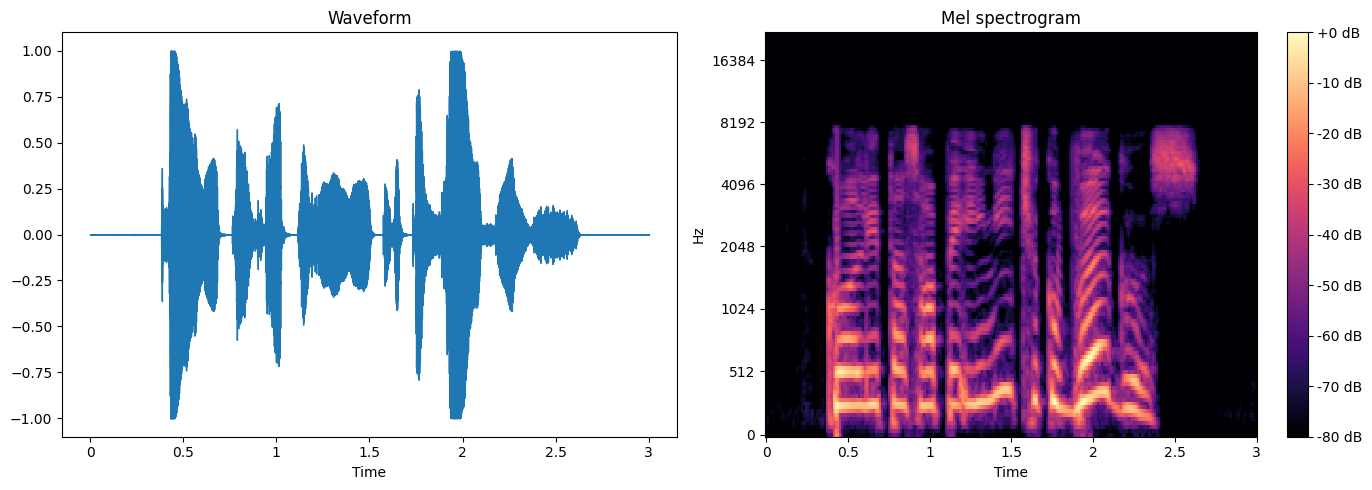

Emotion: neutral, Path: /content/drive/MyDrive/PPDM/VOICE/DATASET/voiceindo/voice/IndoWaveSentiment/Actor_04/04-01-01-01.wav


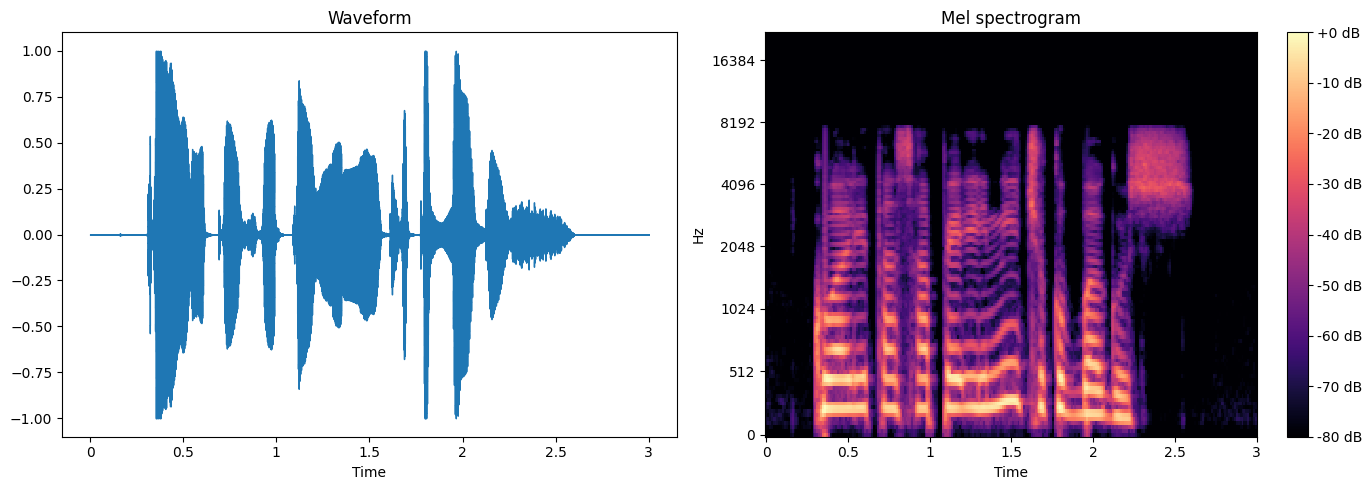

Emotion: surprise, Path: /content/drive/MyDrive/PPDM/VOICE/DATASET/voiceindo/voice/IndoWaveSentiment/Actor_04/04-03-02-01.wav


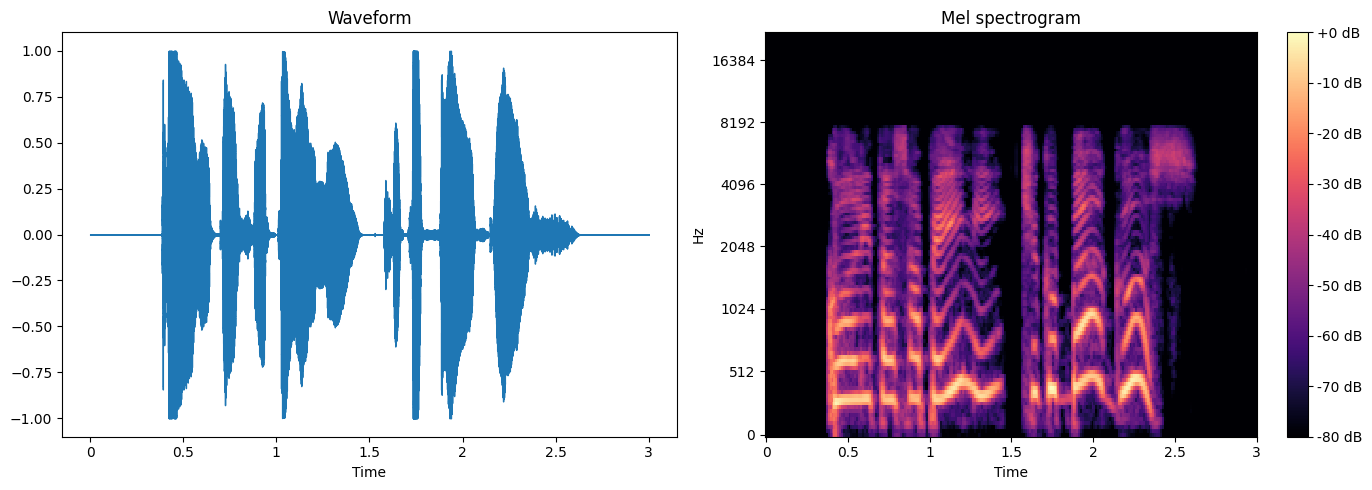

In [ ]:
import numpy as np
from IPython.display import Audio #buat nampilin audio

# Visualisasi audio dengan waveform and mel spectrogram
def plot_waveform_mel(file_path):
    plt.figure(figsize=(14, 5))

    # Load audio file
    y, sr = librosa.load(file_path, sr=None)

    # Plot waveform
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform')

    # Plot mel spectrogram
    plt.subplot(1, 2, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
    S_DB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')

    plt.tight_layout()
    plt.show()

selected_samples = df_labeling.groupby('emotion').first().reset_index()

# plot setiap sample
for i in selected_samples.index:
    file_path = selected_samples.loc[i, 'path']  # Get the file path for each sample
    print(f"Emotion: {selected_samples.loc[i, 'emotion']}, Path: {file_path}")
    plot_waveform_mel(file_path)
    display(Audio(file_path))

#MFCC

In [ ]:
#  MFCC ekstraksi fitur
import librosa
import numpy as np

def extract_mfcc(file_path, n_mfcc=20, frame_length=0.025, hop_length=0.01, preemphasis=0.97):
    y, sr = librosa.load(file_path)
    y = np.append(y[0], y[1:] - preemphasis * y[:-1])

    frame_length = int(frame_length * sr)
    hop_length = int(hop_length * sr)

    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=frame_length)
    mfccs_mean = np.mean(mfccs, axis=1)  # Taking mean of MFCCs over time
    return mfccs_mean

# Example usage:
mfcc_features = []

for path in df_labeling['path']:
    mfcc = extract_mfcc(path, n_mfcc=20, frame_length=0.025, hop_length=0.01, preemphasis=0.97)
    mfcc_features.append(mfcc)

# CConvert ke df
mfcc_df = pd.DataFrame(mfcc_features, columns=[f'mfcc_{i+1}' for i in range(mfcc_features[0].shape[0])])

# Gabung
df_labeling = pd.concat([df_labeling, mfcc_df], axis=1)

excel_file = 'df_labeling.xlsx'
df_labeling.to_excel(excel_file, index=False)

df_labeling.head()

,duration,emotion,path,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20
0,3.000000,happy,/content/drive/MyDrive/PPDM/VOICE/DATASET/voic...,-591.680115,24.409889,-19.710987,34.769245,-46.587162,14.798630,-23.111948,...,-4.865387,-16.366411,-7.627349,-11.552228,-0.345889,-18.317152,-0.007436,-8.176105,-3.351254,-4.144442
1,3.000000,surprise,/content/drive/MyDrive/PPDM/VOICE/DATASET/voic...,-569.365234,17.511192,-34.159550,29.348915,-53.707680,11.643673,-26.932579,...,-9.061146,-18.975080,-5.223973,-8.926309,3.960320,-7.696305,7.918643,-4.125655,0.575974,0.127496
2,3.300000,disappointed,/content/drive/MyDrive/PPDM/VOICE/DATASET/voic...,-586.788574,57.365505,-25.446299,54.186592,-44.427105,4.359712,-18.989052,...,-9.581300,-16.391396,-6.400670,-14.758161,3.555922,-21.716995,-0.823263,-10.022170,-8.883214,-9.448096
3,3.000000,surprise,/content/drive/MyDrive/PPDM/VOICE/DATASET/voic...,-528.265015,15.595710,-37.030224,37.572765,-60.202595,14.539223,-31.031902,...,-7.638954,-21.799725,-7.109357,-12.292539,2.540653,-10.263038,11.135468,-4.825623,-1.480220,-3.558758
4,3.699932,disgust,/content/drive/MyDrive/PPDM/VOICE/DATASET/voic...,-550.385803,41.630032,-26.027218,42.181332,-38.786751,8.161894,-18.486593,...,-3.938036,-14.724395,-6.493228,-13.083334,3.371296,-17.211487,-1.325565,-7.880005,-8.105894,-7.520810


In [ ]:
min_duration = df_labeling['duration'].min()
max_duration = df_labeling['duration'].max()

print(f"Shortest Duration: {min_duration} seconds")
print(f"Longest Duration: {max_duration} seconds")


Shortest Duration: 2.9995691609977326 seconds
Longest Duration: 3.8 seconds


# MODELING

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_labeling.drop(columns=['duration', 'emotion', 'path'])
y = df_labeling['emotion']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf = RandomForestClassifier()

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

all_predictions = []
all_true_labels = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    all_predictions.extend(y_pred)
    all_true_labels.extend(y_test)


    # Evaluasi setiap fold
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    accuracy_scores.append(accuracy)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])


mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-Score: {mean_f1}')

Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

disappointed       0.69      0.90      0.78        10
     disgust       0.85      0.85      0.85        13
       happy       0.73      0.73      0.73        15
     neutral       0.80      0.62      0.70        13
    surprise       0.78      0.78      0.78         9

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.76        60

Accuracy: 0.8666666666666667
              precision    recall  f1-score   support

disappointed       0.73      0.89      0.80         9
     disgust       1.00      0.79      0.88        14
       happy       0.88      0.93      0.90        15
     neutral       0.92      0.86      0.89        14
    surprise       0.78      0.88      0.82         8

    accuracy                           0.87        60
   macro avg       0.86      0.87      0.86        60
weighted avg       

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_labeling.drop(columns=['duration', 'emotion', 'path'])
y = df_labeling['emotion']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
svm_model = SVC()

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

all_predictions = []
all_true_labels = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svm_model.fit(X_train, y_train)

    y_pred = svm_model.predict(X_test)

    all_predictions.extend(y_pred)
    all_true_labels.extend(y_test)


    # Evaluasi setiap fold
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    accuracy_scores.append(accuracy)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])


mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-Score: {mean_f1}')

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

disappointed       0.82      0.90      0.86        10
     disgust       0.92      0.92      0.92        13
       happy       0.72      0.87      0.79        15
     neutral       1.00      0.77      0.87        13
    surprise       0.75      0.67      0.71         9

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.85      0.83      0.83        60

Accuracy: 0.8833333333333333
              precision    recall  f1-score   support

disappointed       1.00      0.78      0.88         9
     disgust       0.93      0.93      0.93        14
       happy       0.82      0.93      0.87        15
     neutral       0.93      1.00      0.97        14
    surprise       0.71      0.62      0.67         8

    accuracy                           0.88        60
   macro avg       0.88      0.85      0.86        60
weighted avg       

# TUNING
SVM + GRIDSEARCH + JUSTMFCC
# **BEST ACCURACY**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

X1 = df_labeling.drop(columns=['duration', 'emotion', 'path'])
y1 = df_labeling['emotion']

# Normalisasi fitur
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Inisialisasi model SVM
svm = SVC()

# Definisikan grid parameter untuk dicari
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Inisialisasi KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search untuk mencari parameter terbaik dengan KFold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=1)
grid_search.fit(X1_scaled, y1)

# Hasil parameter terbaik
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluasi model terbaik dengan KFold cross-validation
cv_results = grid_search.cv_results_
print("\nCV Results:")
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print(f"Mean Accuracy1: {mean_score:.4f}, Standard Deviation: {std_score:.4f} for Parameters: {params}")

# Tampilkan laporan klasifikasi untuk model terbaik
best_model = grid_search.best_estimator_
y1_pred = best_model.predict(X1_scaled)
print("\nClassification Report:")
print(classification_report(y1, y1_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

CV Results:
Mean Accuracy1: 0.1600, Standard Deviation: 0.0544 for Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Mean Accuracy1: 0.7333, Standard Deviation: 0.0279 for Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Mean Accuracy1: 0.1867, Standard Deviation: 0.0846 for Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Mean Accuracy1: 0.7333, Standard Deviation: 0.0279 for Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Mean Accuracy1: 0.2400, Standard Deviation: 0.0663 for Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Mean Accuracy1: 0.7333, Standard Deviation: 0.0279 for Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Mean Accuracy1: 0.1567, Standard Deviation: 0.0478 for Parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Mean Accuracy1: 0.7333, Standard Deviation: 0.0279 for Parameters: {'C': 0.1, 'gamma': 0.001, '

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_labeling.drop(columns=['duration', 'emotion', 'path'])
y = df_labeling['emotion']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
svm_tunned_mfcc = SVC(C=10, gamma= 0.1, kernel= 'rbf')

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

all_predictions = []
all_true_labels = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svm_tunned_mfcc.fit(X_train, y_train)

    y_pred = svm_tunned_mfcc.predict(X_test)

    all_predictions.extend(y_pred)
    all_true_labels.extend(y_test)


    # Evaluasi setiap fold
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    accuracy_scores.append(accuracy)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])


mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-Score: {mean_f1}')

Accuracy: 0.9333333333333333
              precision    recall  f1-score   support

disappointed       1.00      1.00      1.00        10
     disgust       1.00      1.00      1.00        13
       happy       0.92      0.80      0.86        15
     neutral       1.00      0.92      0.96        13
    surprise       0.75      1.00      0.86         9

    accuracy                           0.93        60
   macro avg       0.93      0.94      0.93        60
weighted avg       0.94      0.93      0.93        60

Accuracy: 0.9666666666666667
              precision    recall  f1-score   support

disappointed       1.00      1.00      1.00         9
     disgust       1.00      0.93      0.96        14
       happy       1.00      0.93      0.97        15
     neutral       0.93      1.00      0.97        14
    surprise       0.89      1.00      0.94         8

    accuracy                           0.97        60
   macro avg       0.96      0.97      0.97        60
weighted avg       

In [ ]:
import pickle

with open('svm_mfcc_onlyy.pkl', 'wb') as f:
    pickle.dump(svm_tunned_mfcc, f)

# BAGAIMANA KALAU MEMAKAI:

1.   MFCC
2.   Chroma
3. Mel Spectogram




In [ ]:
import os
import glob
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt

emotions = {
    '01': 'neutral',
    '02': 'happy',
    '03': 'surprise',
    '04': 'disgust',
    '05': 'disappointed',
}

observed_emotions = ['neutral', 'happy', 'surprise', 'disgust', 'disappointed']

def load_data():
    labels = []
    durations = []
    path = []
    for file in glob.glob("/content/drive/MyDrive/PPDM/VOICE/DATASET/voiceindo/voice/IndoWaveSentiment/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[1]]
        if emotion in observed_emotions:
            labels.append(emotion)
            duration = calculate_duration(file)
            durations.append(duration)
            path.append(file)

    return durations, labels, path

def calculate_duration(file_path):
    y, sr = librosa.load(file_path, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    return duration

durations, labels, path = load_data()

df_labeling_4f = pd.DataFrame({'duration': durations, 'emotion': labels, 'path':path})

print(df_labeling_4f.sample(5))

num_rows, num_columns = df_labeling_4f.shape

print(f"Number of data points: {num_rows}")


     duration   emotion                                               path
47        3.5   disgust  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
137       3.0  surprise  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
165       3.0     happy  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
62        3.0  surprise  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
284       3.3   disgust  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...
Number of data points: 300


In [ ]:
# Mel Spectrogram features
def extract_mel_spectrogram(file_path, n_mels=128):
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_spectrogram_mean = np.mean(mel_spectrogram, axis=1)
    return mel_spectrogram_mean

#  MFCC features
def extract_mfcc(file_path, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    return mfccs_mean

# Chroma features
def extract_chroma(file_path):
    y, sr = librosa.load(file_path, sr=None)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    return chroma_mean

# Extract features
mfcc_features = []
chroma_features = []
mel_spectrogram_features = []



for path in df_labeling_4f['path']:
    mfcc = extract_mfcc(path)
    mfcc_features.append(mfcc)

    chroma = extract_chroma(path)
    chroma_features.append(chroma)

    mel_spec = extract_mel_spectrogram(path)
    mel_spectrogram_features.append(mel_spec)



mfcc_df = pd.DataFrame(mfcc_features, columns=[f'mfcc_{i+1}' for i in range(len(mfcc_features[0]))])
chroma_df = pd.DataFrame(chroma_features, columns=[f'chroma_{i+1}' for i in range(len(chroma_features[0]))])
mel_spec_df = pd.DataFrame(mel_spectrogram_features, columns=[f'mel_spec_{i+1}' for i in range(len(mel_spectrogram_features[0]))])

# Concatenate all DataFrames into df_labeling_4f
df_labeling_4f = pd.concat([df_labeling_4f, mfcc_df, chroma_df, mel_spec_df], axis=1)

# Display the DataFrame with all features
print(df_labeling_4f.head())

excel_file = 'df_labeling_4f.xlsx'
df_labeling_4f.to_excel(excel_file, index=False)

   duration       emotion                                               path  \
0  3.000000         happy  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...   
1  3.000000      surprise  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...   
2  3.300000  disappointed  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...   
3  3.000000      surprise  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...   
4  3.699932       disgust  /content/drive/MyDrive/PPDM/VOICE/DATASET/voic...   

       mfcc_1      mfcc_2     mfcc_3     mfcc_4     mfcc_5     mfcc_6  \
0 -367.377228   85.852196  -9.727199  27.667912   3.529114 -21.447645   
1 -337.541382   80.928482 -22.014170  19.591690  -0.901683 -25.867897   
2 -349.355530  107.095268   2.833035  29.666063  15.181501 -17.987726   
3 -317.205475   92.022514 -27.417646  28.351988   0.129989 -29.975351   
4 -337.721863  105.419792  -8.371514  27.267620  11.169436 -18.124754   

     mfcc_7  ...  mel_spec_119  mel_spec_120  mel_spec_121  mel_spec_122  \
0  4

In [ ]:
df_check = df_labeling_4f.shape
df_check

(300, 156)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Features and labels
X = df_labeling_4f.drop(columns=['duration', 'emotion', 'path'])
y = df_labeling_4f['emotion']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Random Forest classifier
RANDOM_MODEL = RandomForestClassifier()

# Variables to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Variables to store predictions and true labels
all_predictions = []
all_true_labels = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    RANDOM_MODEL.fit(X_train, y_train)

    # Make predictions
    y_pred = RANDOM_MODEL.predict(X_test)

    # Save predictions and true labels
    all_predictions.extend(y_pred)
    all_true_labels.extend(y_test)


    # Evaluate the model
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    accuracy_scores.append(accuracy)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])


# Calculate mean of evaluation metrics
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-Score: {mean_f1}')


Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

disappointed       0.56      0.90      0.69        10
     disgust       0.64      0.69      0.67        13
       happy       0.85      0.73      0.79        15
     neutral       0.67      0.31      0.42        13
    surprise       0.64      0.78      0.70         9

    accuracy                           0.67        60
   macro avg       0.67      0.68      0.65        60
weighted avg       0.68      0.67      0.65        60

Accuracy: 0.7666666666666667
              precision    recall  f1-score   support

disappointed       0.62      0.89      0.73         9
     disgust       1.00      0.86      0.92        14
       happy       0.82      0.60      0.69        15
     neutral       0.91      0.71      0.80        14
    surprise       0.54      0.88      0.67         8

    accuracy                           0.77        60
   macro avg       0.78      0.79      0.76        60
weighted avg       

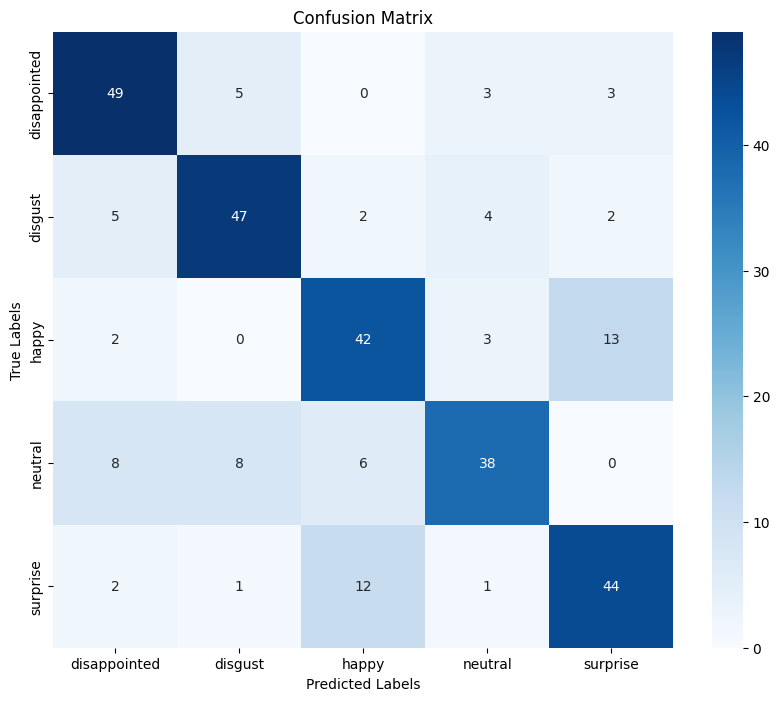

In [ ]:

# Create confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)


import seaborn as sns
plt.figure(figsize=(10, 8))
# Access classes_ from the fitted model
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=RANDOM_MODEL.classes_, yticklabels=RANDOM_MODEL.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Assuming df_labeling_4f is your DataFrame with features and labels

# Features and labels
X = np.array(df_labeling_4f.drop(columns=['duration', 'emotion', 'path']))
y = np.array(df_labeling_4f['emotion'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)

# Define the KFold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the SVM classifier
svm_modelf = SVC()

# Variables to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Variables to store predictions and true labels
all_predictions = []
all_true_labels = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    svm_modelf.fit(X_train, y_train)

    # Make predictions
    y_pred = svm_modelf.predict(X_test)

    # Save predictions and true labels
    all_predictions.extend(y_pred)
    all_true_labels.extend(y_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    accuracy_scores.append(accuracy)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])

    # Print or store individual fold results if needed
    print(f'Fold Accuracy: {accuracy}')
    print(classification_report(y_test, y_pred))

# Calculate mean of evaluation metrics
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-Score: {mean_f1}')


Fold Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.58      0.70      0.64        10
           1       0.53      0.62      0.57        13
           2       0.86      0.80      0.83        15
           3       0.70      0.54      0.61        13
           4       0.67      0.67      0.67         9

    accuracy                           0.67        60
   macro avg       0.67      0.66      0.66        60
weighted avg       0.68      0.67      0.67        60

Fold Accuracy: 0.7
              precision    recall  f1-score   support

           0       0.58      0.78      0.67         9
           1       0.64      0.50      0.56        14
           2       0.63      0.80      0.71        15
           3       0.87      0.93      0.90        14
           4       1.00      0.38      0.55         8

    accuracy                           0.70        60
   macro avg       0.74      0.68      0.67        60
weighted avg       0.73 

# PERLU TUNING?
Fitur:
1.   MFCC
2.   Chroma
3. Mel Spectogram

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

X1 = df_labeling_4f.drop(columns=['duration', 'emotion', 'path'])
y1 = df_labeling_4f['emotion']

# Normalisasi fitur
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1)

# Inisialisasi model SVM
rf = RandomForestClassifier(random_state=42)

# Definisikan grid parameter untuk dicari
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Inisialisasi KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search untuk mencari parameter terbaik dengan KFold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=1)
grid_search.fit(X1_scaled, y1)

# Hasil parameter terbaik
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluasi model terbaik dengan KFold cross-validation
cv_results = grid_search.cv_results_
print("\nCV Results:")
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print(f"Mean Accuracy1: {mean_score:.4f}, Standard Deviation: {std_score:.4f} for Parameters: {params}")

# Tampilkan laporan klasifikasi untuk model terbaik
best_model = grid_search.best_estimator_
y1_pred = best_model.predict(X1_scaled)
print("\nClassification Report:")
print(classification_report(y1, y1_pred))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

CV Results:
Mean Accuracy1: 0.7467, Standard Deviation: 0.0452 for Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Accuracy1: 0.7467, Standard Deviation: 0.0427 for Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Accuracy1: 0.7567, Standard Deviation: 0.0403 for Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Mean Accuracy1: 0.7600, Standard Deviation: 0.0271 for Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Mean Accuracy1: 0.7433, Standard Deviation: 0.0343 for Parameters: {'criterion': 'gini', 'ma

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_labeling_4f.drop(columns=['duration', 'emotion', 'path'])
y = df_labeling_4f['emotion']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_tunned = RandomForestClassifier(criterion= 'entropy', max_depth= 10, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 200)

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

all_predictions = []
all_true_labels = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf_tunned.fit(X_train, y_train)

    y_pred = rf_tunned.predict(X_test)

    all_predictions.extend(y_pred)
    all_true_labels.extend(y_test)


    # Evaluasi setiap fold
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    accuracy_scores.append(accuracy)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])


mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-Score: {mean_f1}')

Accuracy: 0.7333333333333333
              precision    recall  f1-score   support

disappointed       0.71      1.00      0.83        10
     disgust       0.73      0.85      0.79        13
       happy       0.91      0.67      0.77        15
     neutral       0.70      0.54      0.61        13
    surprise       0.60      0.67      0.63         9

    accuracy                           0.73        60
   macro avg       0.73      0.74      0.73        60
weighted avg       0.75      0.73      0.73        60

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

disappointed       0.80      0.89      0.84         9
     disgust       1.00      0.86      0.92        14
       happy       0.91      0.67      0.77        15
     neutral       0.87      0.93      0.90        14
    surprise       0.58      0.88      0.70         8

    accuracy                           0.83        60
   macro avg       0.83      0.84      0.83        60
weighted avg       

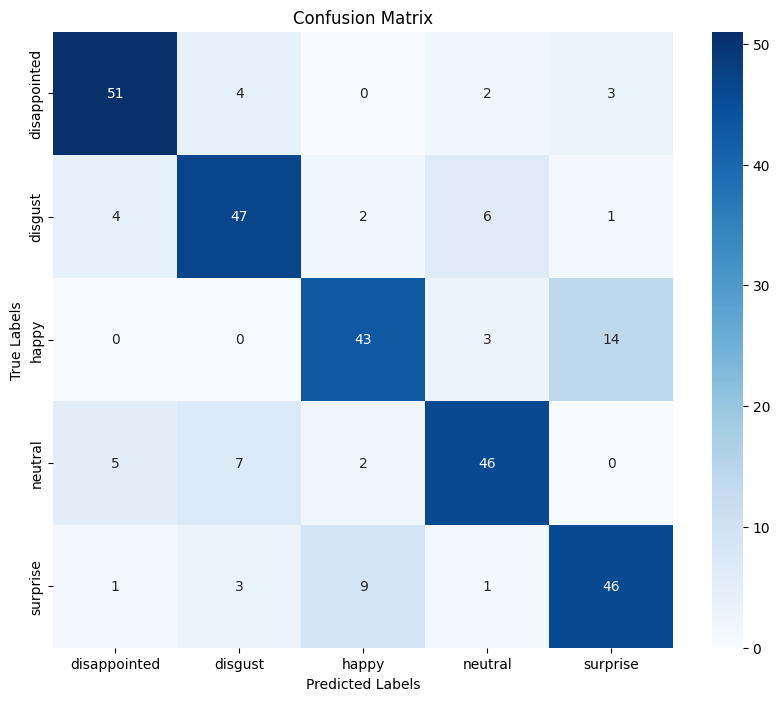

In [ ]:

# Create confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)


import seaborn as sns
plt.figure(figsize=(10, 8))
# Access classes_ from the fitted model
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_tunned.classes_, yticklabels=rf_tunned.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

SVM TUNNED+5FEATURE

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np

X2 = df_labeling_4f.drop(columns=['duration', 'emotion', 'path'])
Y2 = df_labeling_4f['emotion']

# Normalisasi fitur
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

# Inisialisasi model SVM
svm = SVC()

# Definisikan grid parameter untuk dicari
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Inisialisasi KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search untuk mencari parameter terbaik dengan KFold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=kfold, n_jobs=-1, verbose=1)
grid_search.fit(X2_scaled, Y2)

# Hasil parameter terbaik
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Evaluasi model terbaik dengan KFold cross-validation
cv_results = grid_search.cv_results_
print("\nCV Results:")
for mean_score, std_score, params in zip(cv_results['mean_test_score'], cv_results['std_test_score'], cv_results['params']):
    print(f"Mean AccuracY2: {mean_score:.4f}, Standard Deviation: {std_score:.4f} for Parameters: {params}")

# Tampilkan laporan klasifikasi untuk model terbaik
best_model = grid_search.best_estimator_
Y2_pred = best_model.predict(X2_scaled)
print("\nClassification Report:")
print(classification_report(Y2, Y2_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

CV Results:
Mean AccuracY2: 0.1433, Standard Deviation: 0.0226 for Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Mean AccuracY2: 0.7733, Standard Deviation: 0.0291 for Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Mean AccuracY2: 0.1533, Standard Deviation: 0.0414 for Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Mean AccuracY2: 0.7733, Standard Deviation: 0.0291 for Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Mean AccuracY2: 0.2467, Standard Deviation: 0.0945 for Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Mean AccuracY2: 0.7733, Standard Deviation: 0.0291 for Parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Mean AccuracY2: 0.2100, Standard Deviation: 0.0638 for Parameters: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Mean AccuracY2: 0.7733, Standard Deviation: 0.0291 for Parameters: {'C': 0.1, 'gamma': 0.001,

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

X = df_labeling_4f.drop(columns=['duration', 'emotion', 'path'])
y = df_labeling_4f['emotion']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
svm_tunned = SVC(C=100, gamma= 0.01, kernel= 'rbf')

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

all_predictions = []
all_true_labels = []

for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    svm_tunned.fit(X_train, y_train)

    y_pred = svm_tunned.predict(X_test)

    all_predictions.extend(y_pred)
    all_true_labels.extend(y_test)


    # Evaluasi setiap fold
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    accuracy_scores.append(accuracy)
    precision_scores.append(report['weighted avg']['precision'])
    recall_scores.append(report['weighted avg']['recall'])
    f1_scores.append(report['weighted avg']['f1-score'])


mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)

print(f'Mean Accuracy: {mean_accuracy}')
print(f'Mean Precision: {mean_precision}')
print(f'Mean Recall: {mean_recall}')
print(f'Mean F1-Score: {mean_f1}')

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

disappointed       0.82      0.90      0.86        10
     disgust       0.86      0.92      0.89        13
       happy       1.00      0.73      0.85        15
     neutral       1.00      0.69      0.82        13
    surprise       0.60      1.00      0.75         9

    accuracy                           0.83        60
   macro avg       0.86      0.85      0.83        60
weighted avg       0.88      0.83      0.84        60

Accuracy: 0.85
              precision    recall  f1-score   support

disappointed       0.80      0.89      0.84         9
     disgust       0.91      0.71      0.80        14
       happy       0.87      0.87      0.87        15
     neutral       0.93      0.93      0.93        14
    surprise       0.70      0.88      0.78         8

    accuracy                           0.85        60
   macro avg       0.84      0.85      0.84        60
weighted avg       0.86      0.85

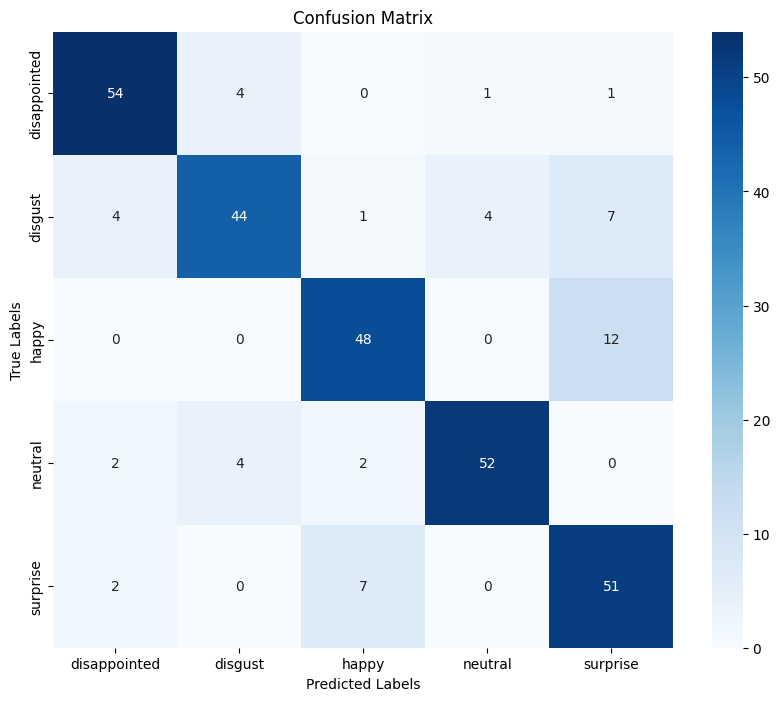

In [ ]:

# Create confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)


import seaborn as sns
plt.figure(figsize=(10, 8))
# Access classes_ from the fitted model
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=svm_tunned.classes_, yticklabels=svm_tunned.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()